In [1]:
# enable auto reload of modules
%load_ext autoreload
%autoreload 2

In [2]:
# This part ensures that we can later import loca         return  torch.tensor(0.) l functions 
# from a module in another directory with relative imports

import os
from os import listdir
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from glob import glob
import logging
import matplotlib.pyplot as plt
import argparse
import socket
import time
from datetime import datetime
from tqdm import tqdm
import numpy as np
from scipy import sparse
from scipy import ndimage
import copy

import torch
import torch.nn as nn        #Dice coeff


from torch import optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

# from src.models.unet import UNet
from src.models.unet import UNet
from src.data.maya_dataset import MayaDataset, MayaTransform
from src.visualization.visualize import visualize_output_of_dataloader, plot_img_and_mask
from src.models.train_model import train_net
from src.models.eval_model import eval_net
from src.models.predict_model import predict_img

In [4]:
# https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gada4437098113fd8683c932e0567f47ba

In [5]:
class PolygonizedMayaDataset(Dataset):
    def __init__(self, mayadataset: MayaDataset,  set = 'test') -> None:
        self.dataset = mayadataset
        self.set = set
        self.st = [[1,1,1],[1,1,1], [1,1,1]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        s = self.dataset[index]

        sample = copy.deepcopy(s)
        for k in s.keys():
            if 'ori_mask' in k:
                if self.set  == 'test':
                    labeled, num_features = ndimage.label(sample[k][0])
                else: 
                    labeled, num_features = ndimage.label( (1 - (sample[k]/255))[0] )

                sample[f'labeled_{k}'] = labeled
        return sample


In [6]:
# Data loaders
dir_img_root = '../data/processed/'
batch_size=2

dataset = MayaDataset(dir_img_root, split="train", transform = MayaTransform(use_augmentations=False))
poly_dataset = PolygonizedMayaDataset(dataset, set = 'train')

n = len(poly_dataset)
# loader = DataLoader(poly_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [7]:
poly_dataset[0].keys()

dict_keys(['idx', 'ori_lidar', 'ori_sentinel1', 'ori_sentinel2', 'ori_mask_building', 'ori_mask_platform', 'ori_mask_aguada', 'lidar', 'sentinel1', 'sentinel2', 'mask_building', 'mask_platform', 'mask_aguada', 'labeled_ori_mask_building', 'labeled_ori_mask_platform', 'labeled_ori_mask_aguada'])

In [8]:
def collate(dt):
    s = {}
    for k in dt[0].keys():
        print(k)
        for i in range(len(dt)):
            if k not in s:
                s[k] = [dt[i][k]]
            else:
                s[k].append(dt[i][k])
    for k in s:
        t = s[k]
        if isinstance(s[k][0], torch.Tensor):
            t = [ i.numpy() for i in s[k]]
        s[k] = np.array(t)
    return s
cl = collate(poly_dataset)

idx
ori_lidar
ori_sentinel1
ori_sentinel2
ori_mask_building
ori_mask_platform
ori_mask_aguada
lidar
sentinel1
sentinel2
mask_building
mask_platform
mask_aguada
labeled_ori_mask_building
labeled_ori_mask_platform
labeled_ori_mask_aguada


In [9]:
def get_all_structure(mask):
    st = []
    for i in range(mask.shape[0]):
        for j in range(1, mask[i].max()+1):
            st.append(mask[i] ==j)
    return np.array(st)

sta = get_all_structure(cl['labeled_ori_mask_aguada'])
stb = get_all_structure(cl['labeled_ori_mask_building'])
stp = get_all_structure(cl['labeled_ori_mask_platform'])

In [14]:
sb = np.count_nonzero(stb, axis=(1,2))

minval = np.argmin(sb[np.nonzero(sb)])
maxval = np.argmax(sb[np.nonzero(sb)])
minval, maxval

(268, 2633)

(array([False,  True]), array([230399,      1]))
(array([255]), array([479]))


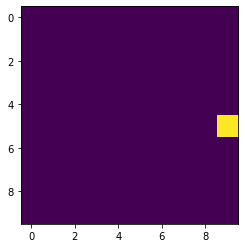

In [23]:
plt.imshow(stb[268])
print(np.unique(stb[268], return_counts=True))
print(np.where(stb[268]))
plt.imshow(stb[268][250:260,470:])

In [13]:
sp = np.count_nonzero(stp, axis=(1,2))

minval = np.min(sp[np.nonzero(sp)])
maxval = np.max(sp[np.nonzero(sp)])
minval, maxval

(1, 109449)

In [12]:
sa = np.count_nonzero(sta, axis=(1,2))

minval = np.min(sa[np.nonzero(sa)])
maxval = np.max(sa[np.nonzero(sa)])
minval, maxval

(13, 129127)